# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP-SVM-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline. 
Complete the code where you see XXXXXXXXXXXXXXXXX (mandatory for everybody)

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


from sklearn.pipeline import make_pipeline

Then load the data from my Google Drive

In [2]:
# from google_drive_downloader import GoogleDriveDownloader as gdd
# gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
# dest_path='./data/features.csv')
# gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
# dest_path='./data/im/nevus-seg.jpg')
# gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
# dest_path='./data/im/nevus.jpg')
# gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
# dest_path='./data/im/melanoma-seg.jpg')
# gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
# dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [3]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))

Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented nevus')

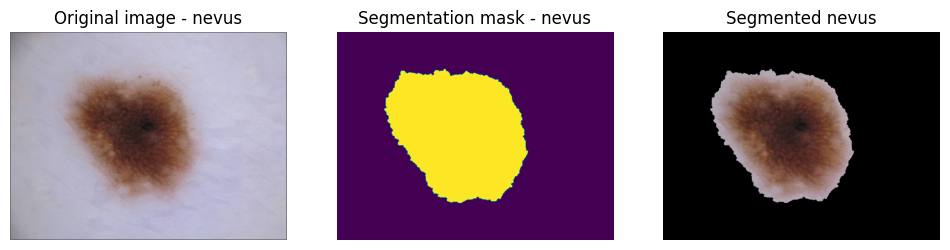

In [4]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

Text(0.5, 1.0, 'Segmented melanoma')

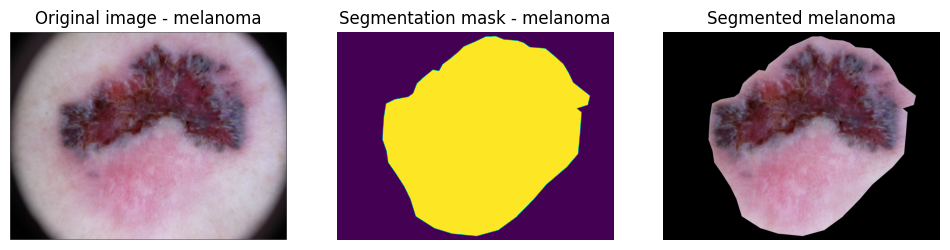

In [5]:
melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [6]:
# Shuffle data randomly
Xp = np.copy(X)
yp = np.copy(y)
np.random.seed(0)
idx = np.random.permutation(N)
Xp = Xp[idx,:]
yp = yp[idx]

We should now test the discriminative power of our features. Fist, let divide the entire data-set into training and test set using the `stratify` option. This will preserve the original proportion between nevus and melanoma also in the training and test set. You can check that from the plot.

Text(0, 0.5, 'Proportion')

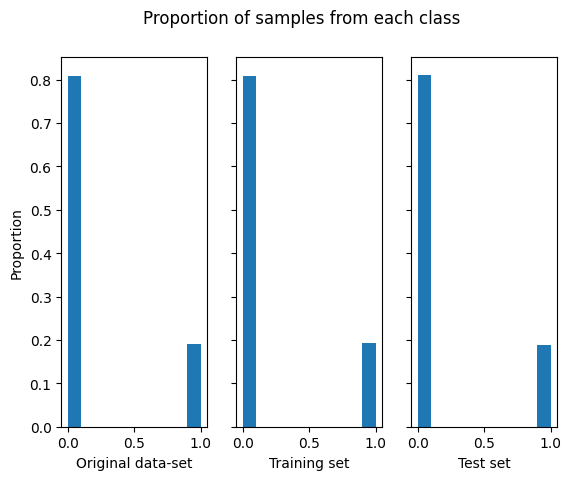

In [7]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, yp, test_size=0.3, random_state=42, stratify=yp)

fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(yp,weights=np.ones_like(yp)/len(yp))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')
axs[0].set_ylabel('Proportion')

As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance. Which is the right way of doing it when having a training and a test set in your opinion ? Should you use together both training and test set ? (For simplicity's sake, we will restrict here to scaling all features).

For scaling features in machine learning models like SVM (Support Vector Machine), it's crucial to treat the training and test sets as separate entities to mimic the real-world scenario where the model encounters unseen data:

1. **Scale Based on the Training Set Only**: Compute the scaling parameters (mean and standard deviation for each feature) using the training set alone. This is because the training set represents the data the model will learn from, and any parameter computation should only be derived from this data to prevent information leak from the test set into the model training process.

2. **Apply the Same Transformation to Both Sets**: Use the scaling parameters computed from the training set to scale both the training and the test set. This means subtract the mean of each feature calculated on the training set from each feature in both the training and test sets and then divide by the respective standard deviations (calculated from the training set).

This approach ensures that the model is not inadvertently learning from the test set and that the test set acts as a stand-in for new, unseen data. It's a crucial step to prevent data leakage, which can lead to overly optimistic performance estimates on the test set.

In [8]:
# Scale data (each feature will have average equal to 0 and unit variance)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

Now, use two simple classification algorithms, for instance LDA and QDA, and look at the confusion matrices. 

**Question**: Comment the results. 

Fitting LDA to training set
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       146
           1       0.65      0.38      0.48        34

    accuracy                           0.84       180
   macro avg       0.76      0.67      0.69       180
weighted avg       0.83      0.84      0.83       180

Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.61764706 0.38235294]]


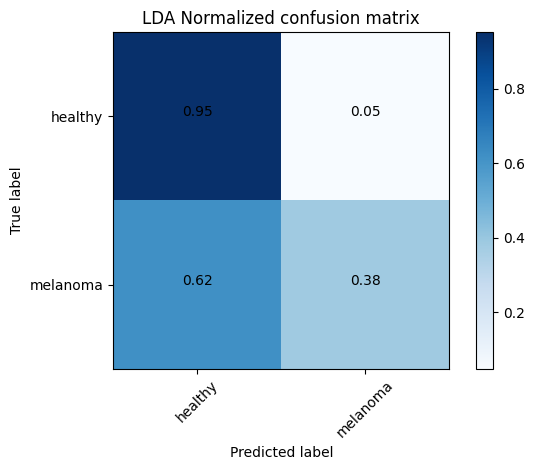

Fitting QDA to training set
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       146
           1       0.65      0.38      0.48        34

    accuracy                           0.84       180
   macro avg       0.76      0.67      0.69       180
weighted avg       0.83      0.84      0.83       180

Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.61764706 0.38235294]]


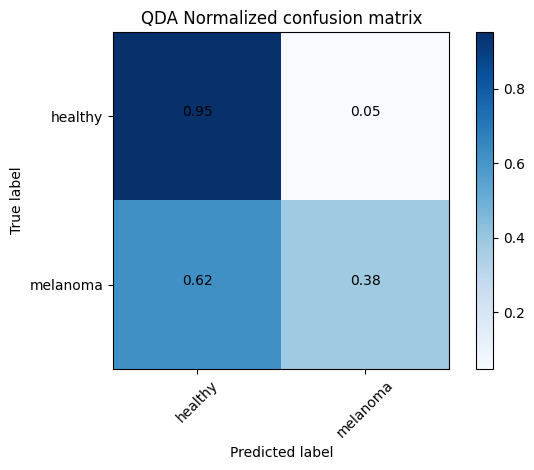

In [9]:
# Fitting LDA
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred = lda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='LDA Normalized confusion matrix')
plt.show()

# Fitting QDA
print("Fitting QDA to training set")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scale, y_train)
y_pred = qda.predict(X_test_scale)
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='QDA Normalized confusion matrix')
plt.show()

Both classifiers have the same true positive rate for "healthy" at 0.95, indicating that 95% of the healthy cases were correctly identified. However, for the "melanoma" class, both classifiers have a true positive rate of 0.62, which means only 62% of actual melanoma cases were correctly predicted.

The false negative rate for melanoma (missed cases of the disease) is quite high for both models at 0.38, implying that 38% of melanoma cases were incorrectly classified as healthy.

The false positive rate for healthy is low at 0.05 for both models, indicating that 5% of healthy cases were incorrectly labeled as melanoma.

Comparing LDA and QDA, we observe that the performance metrics are identical in this case:

1. **Data Distribution**: LDA assumes that the predictor variables are normally distributed and have the same covariance matrix for each class, whereas QDA allows for each class to have its own covariance matrix and does not assume normal distribution. If the actual data follows the assumptions made by LDA, then LDA and QDA might perform similarly.

2. **Overfitting**: QDA might be overfitting to the training data. Overfitting can reduce the classifier's ability to generalize, which might not show an advantage in the test set reflected by the confusion matrix.

3. **Data Complexity**: If the decision boundary between classes is relatively linear, then LDA would be expected to perform as well as QDA since there would be little benefit to the more flexible boundary that QDA can provide.

The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it  with LDA, QDA and K-NN.

To obtain a more reliable estimate of the model's performance, cross-validation can be used. Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The most common form is k-fold cross-validation.

**k-Fold Cross-Validation** works by dividing the dataset into k-groups (or folds). For each unique group:
- The model is trained on the k-1 other groups.
- The trained model is evaluated on the unique group used as the test set.

The process is repeated k times, with each of the k groups used exactly once as the test set. The k results can then be averaged to produce a single estimation. The advantage of this method is that it matters less how the data gets divided; every data point gets to be in a test set exactly once and gets to be in a training set k-1 times.

In [10]:
# Set up the cross-validation scheme
k_folds = 5

# Initialize models
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
knn = KNeighborsClassifier(n_neighbors = 5) 

# For each model, perform k-fold cross-validation
for model_name, model in [('LDA', lda), ('QDA', qda), ('k-NN', knn)]:
    
    # Pipeline that first scales the data then applies the model
    pipeline = make_pipeline(StandardScaler(), model)
    
    # Evaluate model
    scores = cross_val_score(pipeline, X, y, cv=k_folds, scoring='accuracy')
    
    print(f"{model_name} accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

LDA accuracy: 0.80 (+/- 0.05)
QDA accuracy: 0.79 (+/- 0.02)
k-NN accuracy: 0.81 (+/- 0.04)


The k-fold cross-validation results suggest a relatively close performance among the LDA, QDA, and k-NN classifiers. With k-NN edging out slightly with an 81% accuracy compared to LDA's 80% and QDA's 79%, the distinction might not be substantial due to the overlaps within their respective margins of error. The small standard deviation in QDA’s results indicates a consistency across different subsets of data, pointing to its stability as a model.

Despite this proximity in performance, there are considerations that might guide the choice of model. The simplicity of LDA, with its assumption of equal covariance across groups, could be a virtue worth considering. A simpler model like LDA can be more interpretable and generally less prone to overfitting compared to more complex ones like QDA. However, if the application area of these models is highly sensitive, where accuracy is paramount—as in medical diagnoses—then the marginally superior performance of k-NN might be more appealing, despite the greater variability indicated by its standard deviation.

While accuracy is a crucial metric, it is by no means the sole factor to consider when evaluating models for deployment. In practice, especially in fields like healthcare, the implications of false negatives and false positives can be significantly different, necessitating a more nuanced evaluation of model performance that includes precision, recall, and the F1-score. These metrics provide a more rounded view of a model’s prediction capabilities, which is critical in scenarios where the cost of a missed diagnosis far outweighs that of a false alarm.

Moreover, the results you see are merely indicative and not prescriptive. They serve as a starting point for further refinement. Models might benefit from hyperparameter tuning, an enriched feature set, or even additional data. For instance, adjusting the number of neighbors in k-NN could lead to improvements. Beyond the realm of cross-validation, external validation with an entirely separate dataset can offer insights into how these models might perform in real-world conditions, reinforcing or challenging the findings from the cross-validation process.

---
When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value using Cross Validation. 

**Question** Do it and plot the confusion matrix. Do you notice anything strange ? Why in your opinion do you have this kind of result ?

---

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])
Best training Score: 0.8166666666666668
Best training params: {'kneighborsclassifier__n_neighbors': 5}
Normalized confusion matrix
[[0.91780822 0.08219178]
 [0.70588235 0.29411765]]


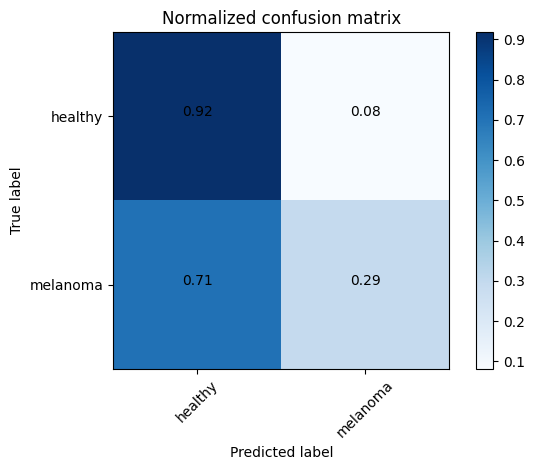

In [11]:
# Looking for the best hyperparameters
neigh = make_pipeline(StandardScaler(), KNeighborsClassifier())

# when using the pipeline, you can print the parameters of the estimator using print(neigh.get_params().keys())`
print(neigh.get_params().keys())
p_grid_KNN = {'kneighborsclassifier__n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring="accuracy", cv=5)
grid_KNN.fit(X_train, y_train)
print("Best training Score: {}".format(grid_KNN.best_score_))
print("Best training params: {}".format(grid_KNN.best_params_))
y_pred = grid_KNN.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In order to deal with this problem we have two possible solutions. 

**First**: Please look at this webpage (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) and try MORE APPROPRIATE scoring functions than accuracy when looking for the best K value of K-NN (thus within the Cross Validation as before..).

Best training Score: 0.6066666666666667
Best training params: {'kneighborsclassifier__n_neighbors': 4}
Normalized confusion matrix
[[0.93835616 0.06164384]
 [0.76470588 0.23529412]]


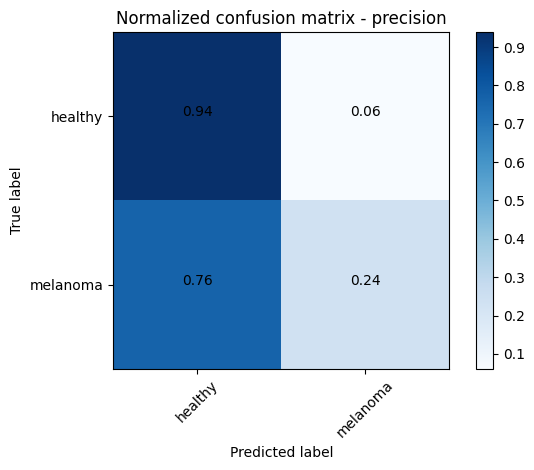

Best training Score: 0.3088235294117647
Best training params: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.84246575 0.15753425]
 [0.55882353 0.44117647]]


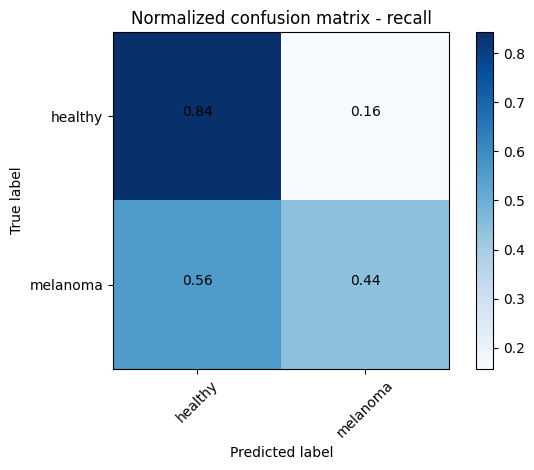

Best training Score: 0.3385166364186328
Best training params: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.84246575 0.15753425]
 [0.55882353 0.44117647]]


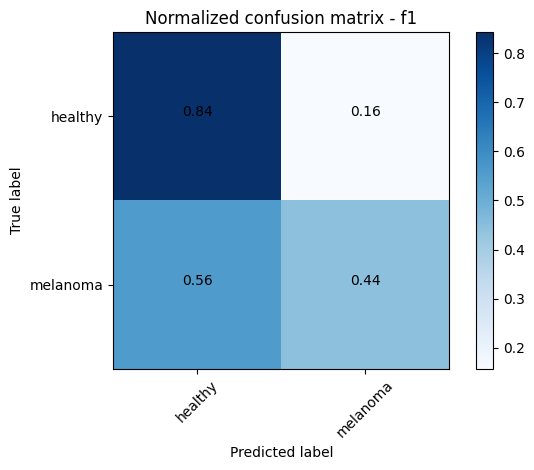

Best training Score: 0.38220610589310866
Best training params: {'kneighborsclassifier__n_neighbors': 5}
Normalized confusion matrix
[[0.91780822 0.08219178]
 [0.70588235 0.29411765]]


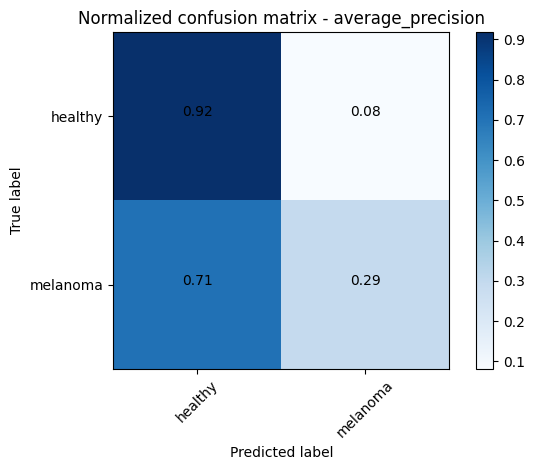

Best training Score: 0.6948982111501316
Best training params: {'kneighborsclassifier__n_neighbors': 5}
Normalized confusion matrix
[[0.91780822 0.08219178]
 [0.70588235 0.29411765]]


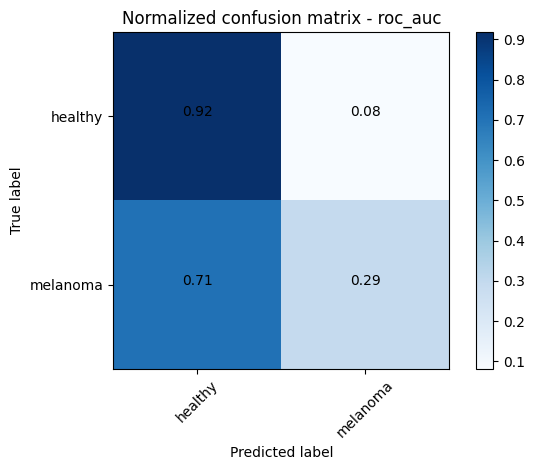

In [12]:
# Looking for the best hyperparameters using more than one metric
scoring = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1', 
           'average_precision': 'average_precision',
            'roc_auc': 'roc_auc'}

for scoring in scoring:
    grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring=scoring, cv=5)
    grid_KNN.fit(X_train, y_train)
    print("Best training Score: {}".format(grid_KNN.best_score_))
    print("Best training params: {}".format(grid_KNN.best_params_))
    y_pred = grid_KNN.predict(X_test)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    # Plot normalized confusion matrix 
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix - {}'.format(scoring))
    plt.show()

**Second**: when dealing with such a problem (the one you should find !) a possible solution would be to oversample a class (which one in your opinion ?) Please look at this web page for more information (https://imbalanced-learn.org/stable/over_sampling.html) and try at least the ADASYN over-sampling strategy (look at the following code...).

NB: if you want to use the naive random oversampling (i.e. randomly sampling with replacement) be careful not to have the same sample both in the training and validation (or test) set during cross-validation (or testing). This would be considered as a data-leakage. 

In [13]:
from imblearn.over_sampling import ADASYN
from collections import Counter

ros = ADASYN(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print(sorted(Counter(y_resampled).items()))

[(0, 339), (1, 333)]


Let's look for the best K in KNN (as before using Cross validation) but this time on the new training set. 

**Question**: Are the results better ? Do they change now if you modify the scoring function ? Why ?

Best training Score: 0.8254075086706105
Best training params: {'kneighborsclassifier__n_neighbors': 2}
Normalized confusion matrix
[[0.82876712 0.17123288]
 [0.44117647 0.55882353]]


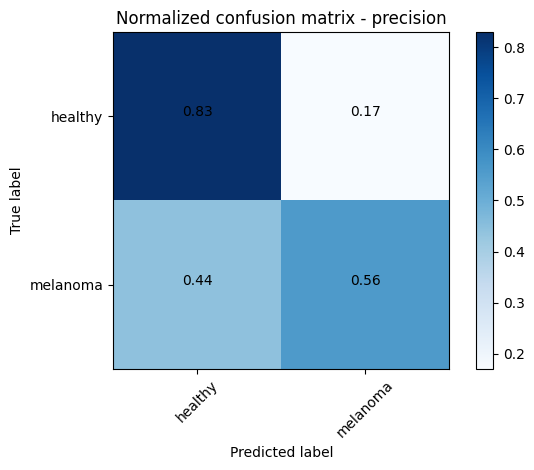

Best training Score: 0.9909543193125282
Best training params: {'kneighborsclassifier__n_neighbors': 1}
Normalized confusion matrix
[[0.7739726  0.2260274 ]
 [0.35294118 0.64705882]]


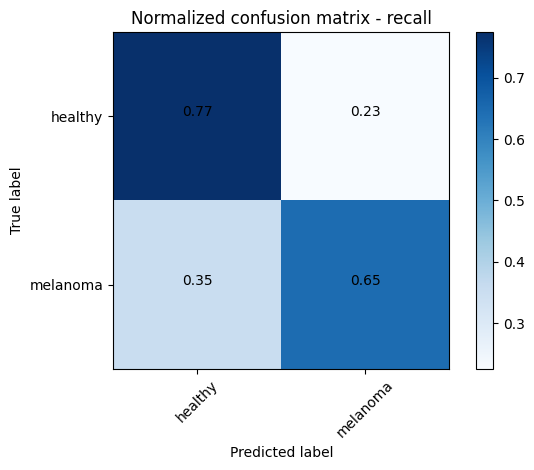

Best training Score: 0.8817962780443555
Best training params: {'kneighborsclassifier__n_neighbors': 2}
Normalized confusion matrix
[[0.82876712 0.17123288]
 [0.44117647 0.55882353]]


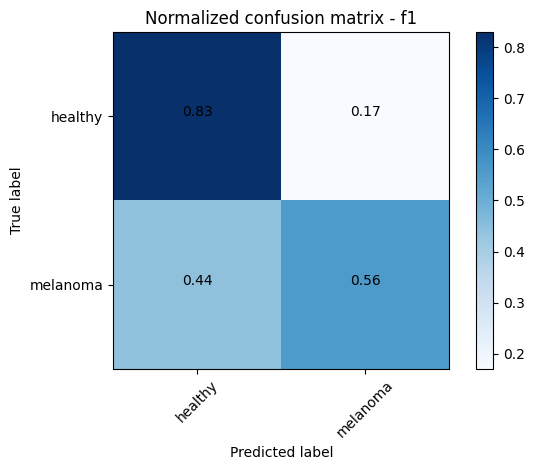

Best training Score: 0.8550824129355306
Best training params: {'kneighborsclassifier__n_neighbors': 4}
Normalized confusion matrix
[[0.70547945 0.29452055]
 [0.29411765 0.70588235]]


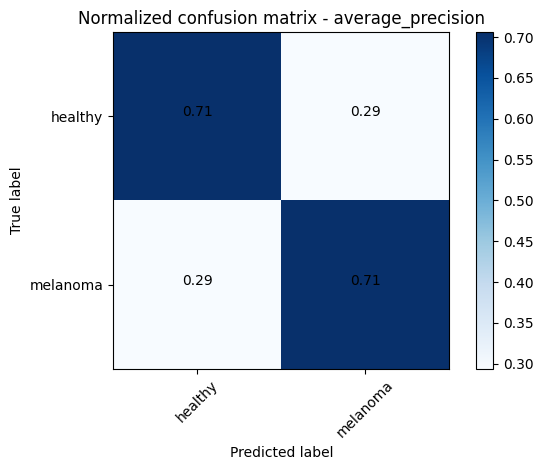

Best training Score: 0.8990708422132295
Best training params: {'kneighborsclassifier__n_neighbors': 4}
Normalized confusion matrix
[[0.70547945 0.29452055]
 [0.29411765 0.70588235]]


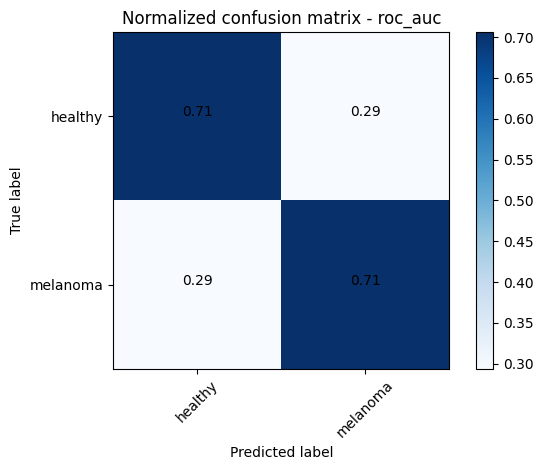

In [14]:
# Looking for the best hyperparameters using more than one metric
scoring = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1', 
           'average_precision': 'average_precision',
            'roc_auc': 'roc_auc'}

for scoring in scoring:
    grid_KNN = GridSearchCV(estimator=neigh, param_grid=p_grid_KNN, scoring=scoring, cv=5)
    grid_KNN.fit(X_resampled, y_resampled)
    print("Best training Score: {}".format(grid_KNN.best_score_))
    print("Best training params: {}".format(grid_KNN.best_params_))
    y_pred = grid_KNN.predict(X_test)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    # Plot normalized confusion matrix 
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix - {}'.format(scoring))
    plt.show()

Let's use the techniques seen today: Perceptron and linear SVM. 

In [15]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_score'].mean(), Perc_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_score'].mean(), Perc_cv['test_score'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC()) 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring='accuracy',return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std() ))

Fitting Perceptron
 Average and std TRAIN CV accuracy : 0.7470833333333334 +- 0.0776231101040291
 Average and std TEST CV accuracy : 0.7333333333333334 +- 0.0560257877132387
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8445833333333332 +- 0.008186201126828514
 Average and std TEST CV accuracy : 0.8150000000000001 +- 0.027588242262078077


We can easily use different scoring functions within the cross validate function of scikit-learn. Check the code.

In [16]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline(StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))


# Fitting linear SVM on original data
print("Fitting Linear SVM")
Lsvm = make_pipeline(StandardScaler(), LinearSVC()) 
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.7470833333333334 +- 0.0776231101040291
 Average and std TEST CV accuracy : 0.7333333333333334 +- 0.0560257877132387
 Average and std TRAIN CV f1 : 0.35373231691129065 +- 0.09920379279242053
 Average and std TEST CV f1 : 0.31268115942028984 +- 0.13015303261005437
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.8445833333333332 +- 0.009185586535436885
 Average and std TEST CV accuracy : 0.8166666666666667 +- 0.030276503540974907
 Average and std TRAIN CV f1 : 0.4232648148148147 +- 0.0545303088347999
 Average and std TEST CV f1 : 0.3179002891479172 +- 0.12405616130539299


**Question** Please do the same on the oversampled data and compare the results with the previous ones. Please note that here you should use the ‘make_pipeline‘ function of Imbalanced scikit-learn. You can look here:  [LINK](https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.make_pipeline.html)


In [17]:
from imblearn.pipeline import make_pipeline as make_pipeline2 

# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,Xp, yp, cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Fitting linear SVM on oversampled data
print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,Xp, yp,cv=5,scoring=('accuracy', 'f1'),return_train_score=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))


Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.6779166666666667 +- 0.06692138837637952
 Average and std TEST CV accuracy : 0.64 +- 0.08698658900466592
 Average and std TRAIN CV f1 : 0.43482291727742783 +- 0.06267577882127977
 Average and std TEST CV f1 : 0.3819810575100647 +- 0.056281050480672015
Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.75875 +- 0.013527235900623257
 Average and std TEST CV accuracy : 0.6966666666666667 +- 0.05286250509051238
 Average and std TRAIN CV f1 : 0.5236461400119602 +- 0.03078861685972656
 Average and std TEST CV f1 : 0.41094336951343396 +- 0.06959177397845218


We can also ask to save the estimated models at each split (i.e. fold) with the option `return_estimator=True`. Using the perceptron, we will look for the best model using the oversampled training data and check the confusion matrix on the test data. 
In that case, we will need to first split the data into train/test and then do the oversampling ONLY in the train data. 

**Question** Do it the same with the linear SVM.

Fitting Perceptron
dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
 Average and std TRAIN CV accuracy : 0.669047619047619 +- 0.07574740964565858
 Average and std TEST CV accuracy : 0.6309523809523809 +- 0.1070105002583059
 Average and std TRAIN CV f1 : 0.4263688562490239 +- 0.05309524411987356
 Average and std TEST CV f1 : 0.34571379428964566 +- 0.07875949805782699
Normalized confusion matrix
[[0.79452055 0.20547945]
 [0.38235294 0.61764706]]


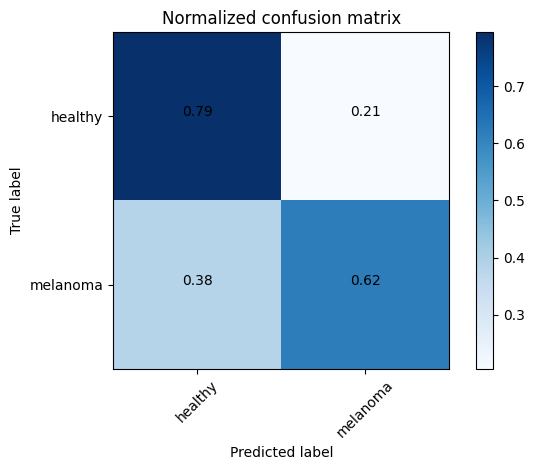

Fitting Linear SVM
 Average and std TRAIN CV accuracy : 0.7553571428571428 +- 0.01426089113179873
 Average and std TEST CV accuracy : 0.6880952380952381 +- 0.0138832187972507
 Average and std TRAIN CV f1 : 0.5215364727124447 +- 0.027488520982421095
 Average and std TEST CV f1 : 0.3907337699169804 +- 0.020955941465071928
Normalized confusion matrix
[[0.76712329 0.23287671]
 [0.32352941 0.67647059]]


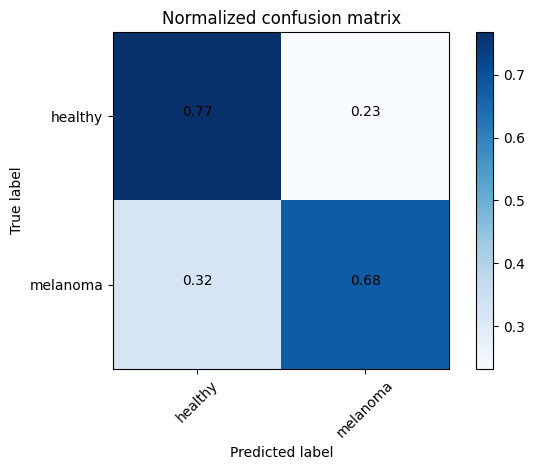

In [18]:
# Fitting Perceptron
print("Fitting Perceptron")
Perc = make_pipeline2(ADASYN(random_state=0),StandardScaler(), Perceptron())
Perc_cv = cross_validate(Perc,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(Perc_cv.keys())
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Perc_cv['train_accuracy'].mean(), Perc_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Perc_cv['test_accuracy'].mean(), Perc_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Perc_cv['train_f1'].mean(), Perc_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Perc_cv['test_f1'].mean(), Perc_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Perc_cv['test_accuracy'])
estimator_best=Perc_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


# Fitting linear SVM
print("Fitting Linear SVM")
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC())
Lsvm_cv = cross_validate(Lsvm,X_train, y_train,cv=5,scoring=('accuracy', 'f1'),return_train_score=True,return_estimator=True)
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(Lsvm_cv['train_accuracy'].mean(), Lsvm_cv['train_accuracy'].std() ))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(Lsvm_cv['test_accuracy'].mean(), Lsvm_cv['test_accuracy'].std() ))
print(" Average and std TRAIN CV f1 : {0} +- {1}".format(Lsvm_cv['train_f1'].mean(), Lsvm_cv['train_f1'].std() ))
print(" Average and std TEST CV f1 : {0} +- {1}".format(Lsvm_cv['test_f1'].mean(), Lsvm_cv['test_f1'].std() ))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_accuracy'])
estimator_best=Lsvm_cv['estimator'][index_best]
y_pred = estimator_best.predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Suppose that there are overlapping classes, we need to set the hyper-parameter C for the SVM model. 

**Question** Use Cross-Validation on the oversampled data to find the best C value. Plot the confusion matrix using the best estimator (as before).

Best training Score: 0.7142857142857143
Best training params: {'linearsvc__C': 0.001}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.26470588 0.73529412]]


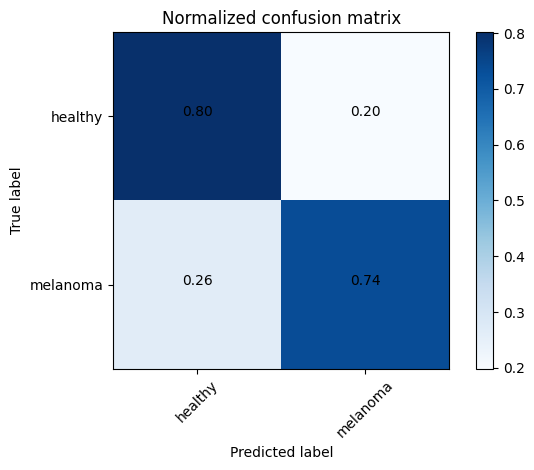

In [19]:
# Looking for the best hyperparameter C 
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC()) 
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Question** Use Cross-Validation on the oversampled data to find the best C and $gamma$ value. Plot the confusion matrix using the best estimator (as before).

Fitting Non-linear SVM to the training set
Best training Score: 0.8142857142857143
Best training params: {'svc__C': 0.1, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.97260274 0.02739726]
 [0.82352941 0.17647059]]


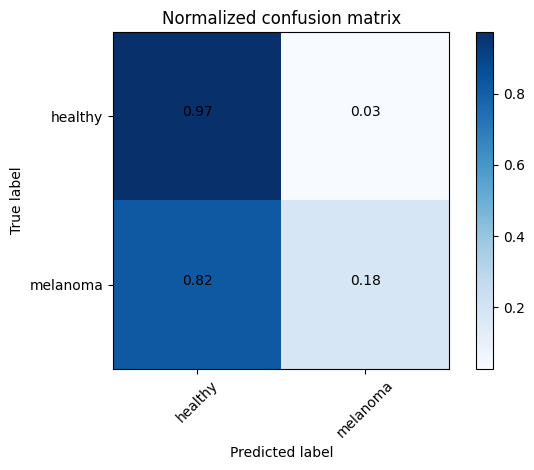

In [20]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), SVC(kernel='rbf')) 
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)
grid_nlsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Use the non-linear SVM with the two strategies seen before (different scoring function and/or oversampled data). Do the results change ? Why in your opinion ?

C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lmcastanedame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

Best training Score: 0.6214285714285713
Best training params: {'svc__C': 4, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.85294118 0.14705882]]


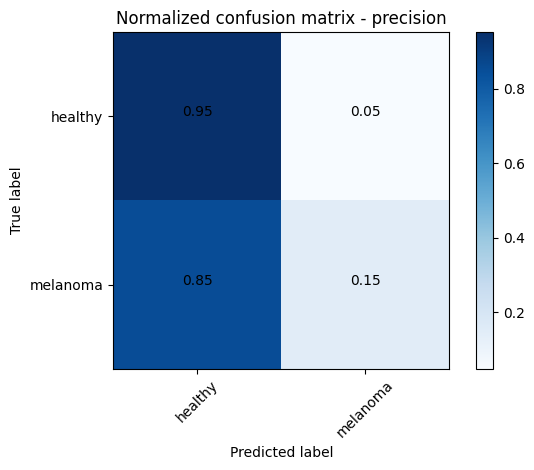

Best training Score: 0.5933823529411765
Best training params: {'svc__C': 3, 'svc__gamma': 0.005}
Normalized confusion matrix
[[0.83561644 0.16438356]
 [0.32352941 0.67647059]]


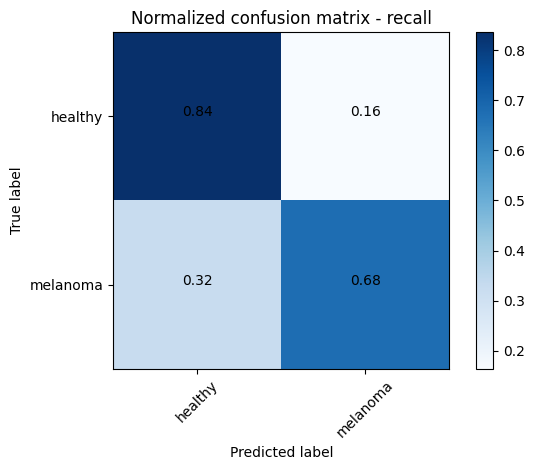

Best training Score: 0.5061294675895694
Best training params: {'svc__C': 7, 'svc__gamma': 0.01}
Normalized confusion matrix
[[0.84931507 0.15068493]
 [0.41176471 0.58823529]]


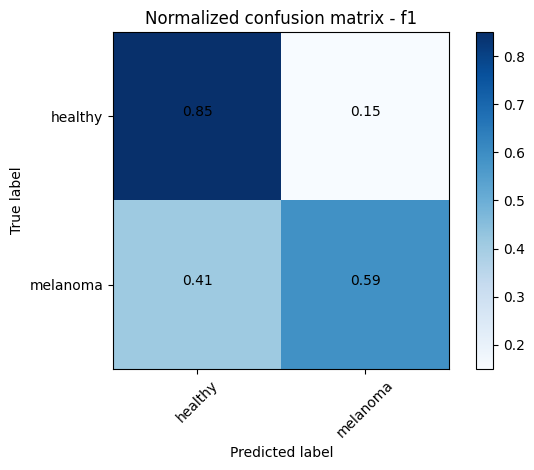

Best training Score: 0.5211094763881916
Best training params: {'svc__C': 7, 'svc__gamma': 0.01}
Normalized confusion matrix
[[0.84931507 0.15068493]
 [0.41176471 0.58823529]]


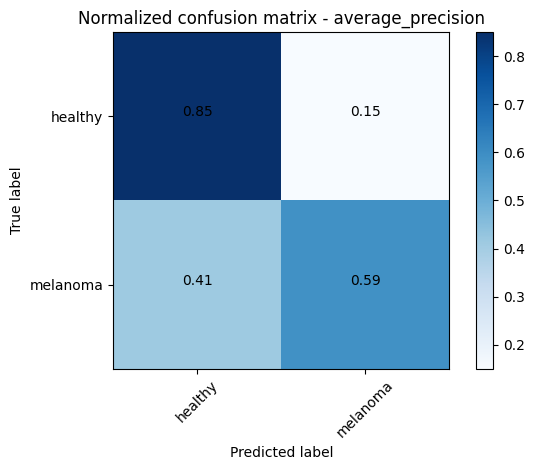

Best training Score: 0.7314146180860404
Best training params: {'svc__C': 2, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.85294118 0.14705882]]


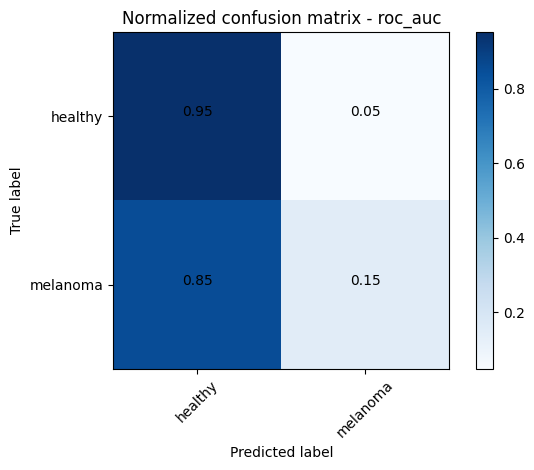

In [21]:
# Non-linear SVM with different scoring metrics
scoring = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1', 
           'average_precision': 'average_precision',
            'roc_auc': 'roc_auc'}

for scoring in scoring:
    grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring=scoring, cv=5)
    grid_nlsvm.fit(X_train, y_train)
    print("Best training Score: {}".format(grid_nlsvm.best_score_))
    print("Best training params: {}".format(grid_nlsvm.best_params_))
    y_pred = grid_nlsvm.predict(X_test)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)

    # Plot normalized confusion matrix 
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix - {}'.format(scoring))
    plt.show()

Fitting Non-linear SVM to the training set


Best training Score: 0.9598341625207297
Best training params: {'svc__C': 2, 'svc__gamma': 0.1}
Normalized confusion matrix
[[0.95205479 0.04794521]
 [0.85294118 0.14705882]]


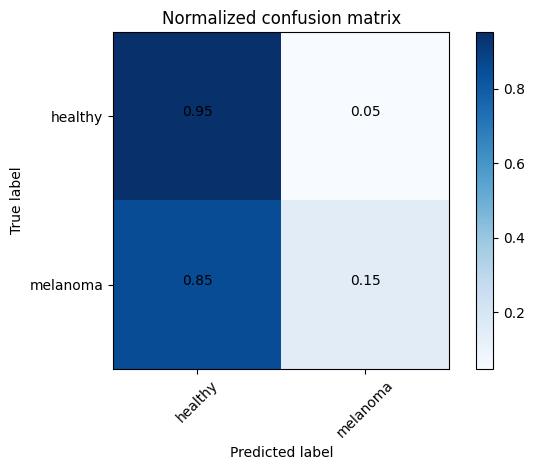

In [22]:
# Non-linear SVM with oversampled data
print("Fitting Non-linear SVM to the training set")
NLsvm = make_pipeline2(StandardScaler(), SVC(kernel='rbf'))
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)
grid_nlsvm.fit(X_resampled, y_resampled)
print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
y_pred = grid_nlsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**Question** Try to draw a conclusion from the different experiments. Which is the best method ? Which scoring function should you use ? Is it worth it to oversample one of the two classes ?

**OPTIONAL** Another interesting question is: what about the number of features ? Can we reduce the dimensionality ? You could use one of the techniques seen during the previous lectures (i.e. PCA) ...

Fitting Linear SVM after PCA
Best training Score: 0.7071428571428571
Best training params: {'linearsvc__C': 0.01}
Normalized confusion matrix
[[0.80136986 0.19863014]
 [0.23529412 0.76470588]]


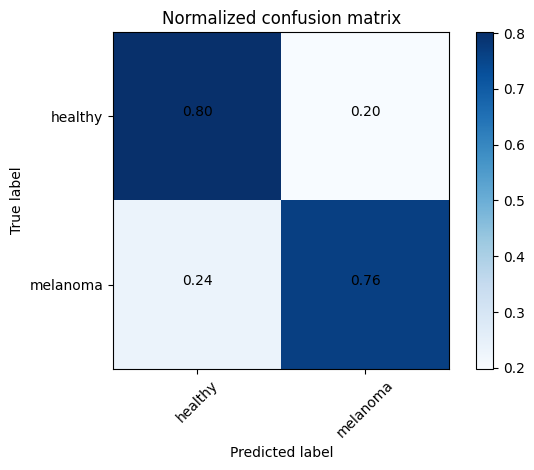

In [23]:
# Test PCA with a linear SVM
print("Fitting Linear SVM after PCA")

Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), PCA(n_components=0.95), LinearSVC()) 
p_grid_lsvm = {'linearsvc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}

grid_lsvm = GridSearchCV(estimator=Lsvm, param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_train, y_train)
print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
y_pred = grid_lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

**OPTIONAL** ... or test the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. f1 score). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 


[2024-03-14 10:43:03] Features: 1/10 -- score: 0.7452380952380953
[2024-03-14 10:43:09] Features: 2/10 -- score: 0.7380952380952381
[2024-03-14 10:43:14] Features: 3/10 -- score: 0.7214285714285715
[2024-03-14 10:43:19] Features: 4/10 -- score: 0.7285714285714286
[2024-03-14 10:43:24] Features: 5/10 -- score: 0.7428571428571429
[2024-03-14 10:43:30] Features: 6/10 -- score: 0.7476190476190476
[2024-03-14 10:43:35] Features: 7/10 -- score: 0.7523809523809524
[2024-03-14 10:43:40] Features: 8/10 -- score: 0.7547619047619047
[2024-03-14 10:43:45] Features: 9/10 -- score: 0.7523809523809524
[2024-03-14 10:43:50] Features: 10/10 -- score: 0.7476190476190476

Best accuracy obtained was: 0.7476190476190476
Indices of the selected features: (0, 4, 5, 7, 8, 19, 22, 26, 27, 28)
Number of selected features: 10


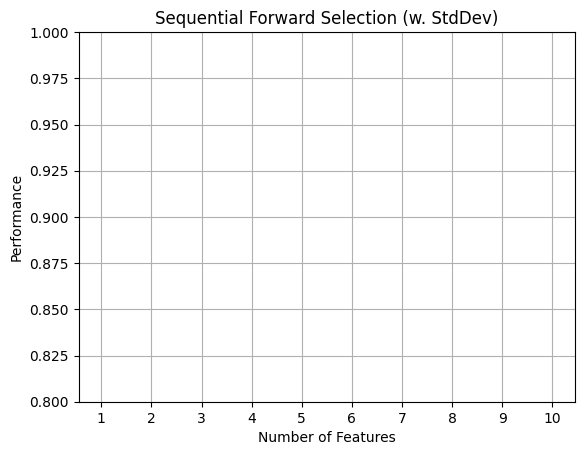

In [25]:
# Implement forward feature selection and/or backward feature selection
# with a linear SVM
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Set up the cross-validation scheme
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize the linear SVM
Lsvm = make_pipeline2(ADASYN(random_state=0),StandardScaler(), LinearSVC(C=1))

# Initialize the SFS
sfs = SFS(Lsvm, 
          k_features=10, 
          forward=True, 
          floating=False, 
          verbose=2,
          scoring='accuracy',
          cv=skf)

# Perform SFS
sfs = sfs.fit(X_train, y_train)

# Print the results
print('Best accuracy obtained was:', sfs.k_score_)
print('Indices of the selected features:', sfs.k_feature_idx_)
print('Number of selected features:', len(sfs.k_feature_idx_))

# Plot the results
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
